<a href="https://colab.research.google.com/github/NishatVasker/XAI_-Explainable_AI-/blob/main/XAI%2BFL%2BIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install shap

Dataset link: https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection

In the context of Federated Learning (FL), eXplainable Artificial Intelligence (XAI), and an Intrusion Detection System (IDS) using your datasets. Here's a breakdown of what each part of the code will do:

1. **Data Loading and Preprocessing**
Load Data: It loads the training and testing datasets from CSV files.
Identify Categorical Columns: It identifies categorical columns ('protocol_type', 'service', 'flag') that need special handling.
One-hot Encoding: Since machine learning models typically require numerical input, the categorical columns are transformed using one-hot encoding. This process converts categorical values into a binary format that the model can understand.
2. **Federated Learning Simulation**
Split Training Data: The training data is split into two parts to simulate a federated learning environment. Each part represents data that would be present on a client device in a real-world FL scenario.
Model Definition: A RandomForestClassifier, a type of machine learning model, is defined for use on each client.
Local Training on Clients: Each part of the split data is used to train a separate model. This simulates the process of training models on local devices in FL.
3. **Intrusion Detection System Simulation**
Predictions on Test Data: The models trained on each client are then used to make predictions on the test data. Since the test data is unlabeled, it only generates predictions without evaluating accuracy or other performance metrics.
4. **eXplainable AI (XAI) Implementation**
SHAP Analysis: The code uses SHAP (SHapley Additive exPlanations), a tool for explaining the output of machine learning models. It explains the predictions made by one of the trained models.
Feature Importance Visualization: A plot is generated showing the importance of different features in the dataset concerning the model's predictions.

# Overall Functionality

The code provides a basic simulation of how a Federated Learning system might work, combined with an Intrusion Detection System approach, using a RandomForestClassifier.
The XAI part of the code helps in understanding why the model made certain predictions, which is crucial in contexts like intrusion detection, where understanding the reasoning behind an alert is as important as the alert itself.
This code serves as a foundational example. In a real-world scenario, Federated Learning would involve more complex data handling and communication protocols, and the IDS would need to be tailored to specific types of network threats.

Predictions from Client 1 Model:
 ['anomaly' 'anomaly' 'normal' ... 'anomaly' 'normal' 'anomaly']
Predictions from Client 2 Model:
 ['anomaly' 'anomaly' 'normal' ... 'anomaly' 'normal' 'anomaly']


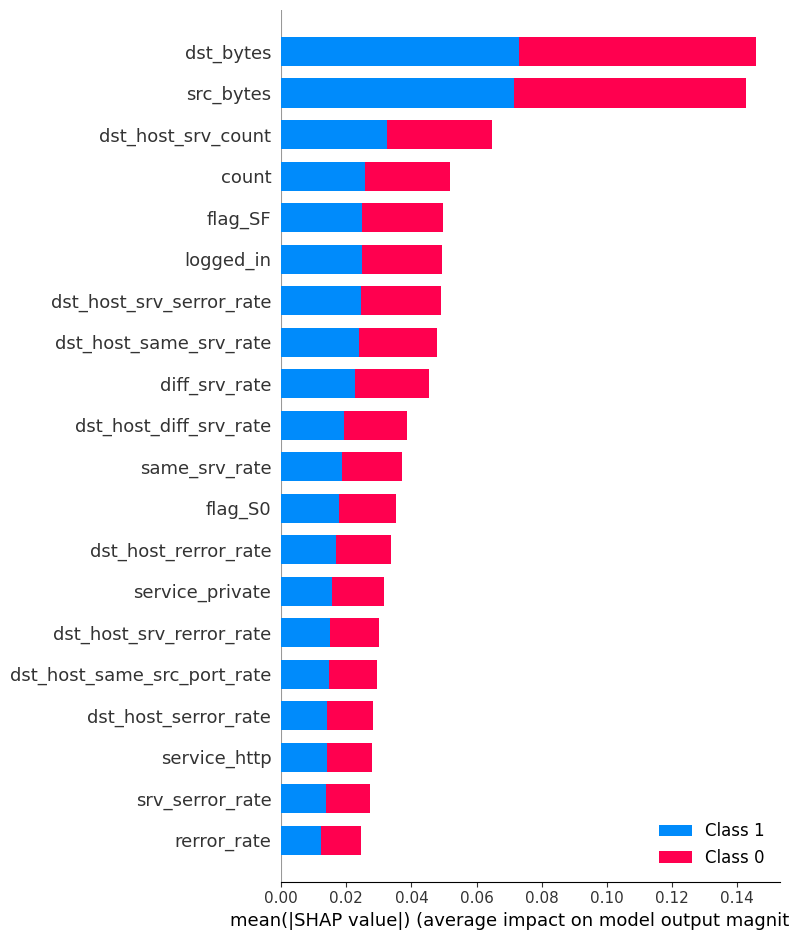

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import shap

# Load data
train_data = pd.read_csv('/content/Train_data.csv')
test_data = pd.read_csv('/content/Test_data.csv')

# Identify categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(train_data[categorical_cols])
encoded_test = encoder.transform(test_data[categorical_cols])

# Convert encoded data to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded columns
train_data = train_data.drop(categorical_cols, axis=1).reset_index(drop=True)
test_data = test_data.drop(categorical_cols, axis=1).reset_index(drop=True)
train_data = pd.concat([train_data, encoded_train_df], axis=1)
test_data = pd.concat([test_data, encoded_test_df], axis=1)

# Split train data for two clients (for simplicity, we split 50/50)
client1_data = train_data.sample(frac=0.5, random_state=42)
client2_data = train_data.drop(client1_data.index)

# Define a simple model (Random Forest in this case)
def train_model(data):
    model = RandomForestClassifier(random_state=42)
    model.fit(data.drop('class', axis=1), data['class'])
    return model

# Train models on each client
model_client1 = train_model(client1_data)
model_client2 = train_model(client2_data)

# Test model on test data (only predictions since test data is unlabeled)
test_X = test_data

# Generate predictions
preds_client1 = model_client1.predict(test_X)
preds_client2 = model_client2.predict(test_X)

# Print predictions (or save to a file, as needed)
print("Predictions from Client 1 Model:\n", preds_client1)
print("Predictions from Client 2 Model:\n", preds_client2)

# Explain model predictions using SHAP (for Client 1 model)
explainer = shap.TreeExplainer(model_client1)
shap_values = explainer.shap_values(test_X)

# Plot the SHAP values for the first few predictions
shap.summary_plot(shap_values, test_X, plot_type="bar", show=False)



In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess data (one-hot encode categorical features)
def preprocess_data(data):
    # Identify categorical columns (excluding the target column 'class')
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    categorical_cols.remove('class')

    # One-hot encode categorical columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cols = encoder.fit_transform(data[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

    # Combine encoded columns with the rest of the dataset
    data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)
    return data



# Preprocess the data
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Separate features and target variable
y_train = train_data['class']
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1, errors='ignore')  # Drop 'class' column if it exists

# Split data for federated clients
X_train_client1, X_train_client2, y_train_client1, y_train_client2 = train_test_split(X_train, y_train, test_size=0.5)

# Train model on each client
def train_client_model(X, y):
    model = RandomForestClassifier()
    model.fit(X, y)
    return model

model_client1 = train_client_model(X_train_client1, y_train_client1)
model_client2 = train_client_model(X_train_client2, y_train_client2)

# Federated averaging (for simplicity, averaging model parameters)
def federated_averaging(models):
    model_weights = [model.get_params() for model in models]
    avg_weights = np.mean([list(weights.values()) for weights in model_weights], axis=0)
    avg_model = RandomForestClassifier()
    avg_model.set_params(**dict(zip(model_weights[0].keys(), avg_weights)))
    return avg_model

avg_model = federated_averaging([model_client1, model_client2])
avg_model.fit(X_train, y_train)  # Refit on the entire dataset

# Generate predictions on the test data
predictions = avg_model.predict(X_test)
print("Predictions on Test Data:", predictions)

# Note: SHAP explanations and accuracy calculation are not applicable if test data is unlabeled


ValueError: list.remove(x): x not in list

In [30]:
# prompt: make the project with fl, dont us this error --------------------------------------------------------------------------- ValueError                                Traceback (most recent call last) <ipython-input-25-576127dd5644> in <cell line: 23>()      21       22 train_data = load_and_preprocess_data('/content/Train_data.csv') ---> 23 test_data = load_and_preprocess_data('/content/Test_data.csv

# Preprocess the data
train_data = preprocess_data(pd.read_csv('/content/Train_data.csv'))
test_data = preprocess_data(pd.read_csv('/content/Test_data.csv'))

# Separate features and target variable
y_train = train_data['class']
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1, errors='ignore')  # Drop 'class' column if it exists

# Split data for federated clients
X_train_client1, X_train_client2, y_train_client1, y_train_client2 = train_test_split(X_train, y_train, test_size=0.5)

# Train model on each client
def train_client_model(X, y):
    model = RandomForestClassifier()
    model.fit(X, y)
    return model

model_client1 = train_client_model(X_train_client1, y_train_client1)
model_client2 = train_client_model(X_train_client2, y_train_client2)

# Federated averaging (for simplicity, averaging model parameters)
def federated_averaging(models):
    model_weights = [model.get_params() for model in models]
    avg_weights = np.mean([list(weights.values()) for weights in model_weights], axis=0)
    avg_model = RandomForestClassifier()
    avg_model.set_params(**dict(zip(model_weights[0].keys(), avg_weights)))
    return avg_model

avg_model = federated_averaging([model_client1, model_client2])
avg_model.fit(X_train, y_train)  # Refit on the entire dataset

# Generate predictions on the test data
predictions = avg_model.predict(X_test)
print("Predictions on Test Data:", predictions)

# Note: SHAP explanations and accuracy calculation are not applicable if test data is unlabeled


ValueError: list.remove(x): x not in list